In [1]:
import os
os.chdir('/pc_win_loss')

In [2]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
import xgboost as xgb
import catboost as catb


from functions.visualizer import *
from src.config import *

## データ取り込み

In [3]:
df_prep = pd.read_pickle('output/df_prep.pkl')
df_prep.head()

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,5,8,6,0,0,14536,17256,0
1,1,10,1,5,0,0,14536,17863,0
2,0,3,10,2,0,0,17409,17256,0
3,1,7,10,8,0,0,19558,18201,0
4,0,4,9,4,0,0,17409,17256,0


# モデル構築

In [4]:
random_state = 0

In [5]:
# 20%の被験者を選ぶ
df_train, df_val = train_test_split(df_prep, test_size=0.2, random_state=random_state)

print(len(df_train))
print(len(df_val))

6400
1600


### LightGBM実装

In [6]:
feature_cols = list(df_train.drop(COL_BLUEWINS, axis=1).columns)

train_x = df_train.drop(COL_BLUEWINS, axis=1)
train_y = df_train[COL_BLUEWINS]

val_x = df_val.drop(COL_BLUEWINS, axis=1)
val_y = df_val[COL_BLUEWINS]

In [7]:
train_x.head()

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
1001,1,11,3,8,1,1,18274,18472
7360,0,6,11,7,0,0,20619,17256
5234,1,6,3,5,1,0,16961,18201
7390,0,9,5,8,0,0,18117,18472
6841,1,9,4,9,0,0,14536,17256


In [8]:
model = lgb.LGBMClassifier(random_state=random_state)
model.fit(train_x, train_y)

LGBMClassifier(random_state=0)

In [9]:
# 検証データを用いて予測
pred_y = model.predict(val_x)

accuracy = accuracy_score(pred_y, val_y)
print(f"accuracy score: {accuracy:0.4f}")

accuracy score: 0.8069


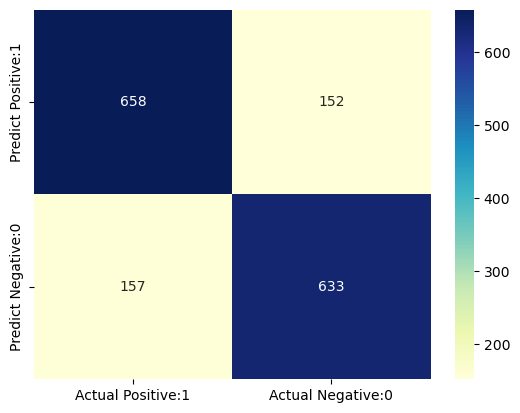

In [10]:
cm = confusion_matrix(val_y, pred_y)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

plt.show()

### 変数重要度の確認

In [11]:
df_importance = pd.DataFrame(model.feature_importances_, index=feature_cols, columns=['importance'])
df_importance['importance'] = df_importance['importance'] / sum(df_importance['importance'])
display(df_importance)

,importance
blueFirstBlood,0.040333
blueKills,0.160667
blueDeaths,0.180333
blueAssists,0.172667
blueEliteMonsters,0.060333
blueDragons,0.035333
blueTotalGold,0.200000
blueTotalExperience,0.150333


In [12]:
# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df): 
    n_features = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot.index                         # 特徴量のカラム名を取得
    plt.yticks(np.arange(n_features), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル

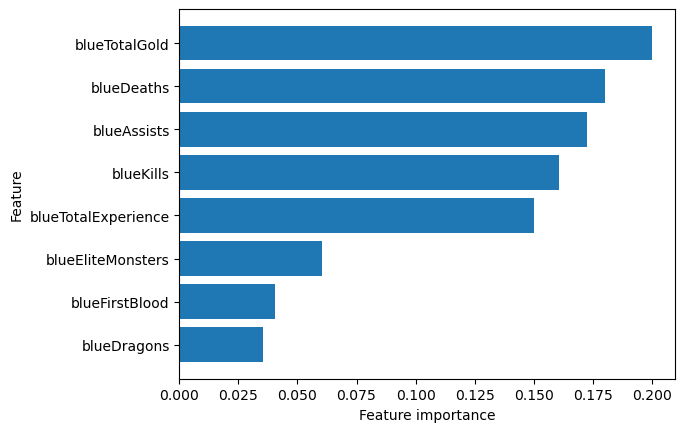

In [13]:
plot_feature_importance(df_importance)

## XGBoost実装

In [14]:
feature_cols = list(df_train.drop(COL_BLUEWINS, axis=1).columns)

train_x = df_train.drop(COL_BLUEWINS, axis=1)
train_y = df_train[COL_BLUEWINS]

val_x = df_val.drop(COL_BLUEWINS, axis=1)
val_y = df_val[COL_BLUEWINS]

In [15]:
train_x.head()

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
1001,1,11,3,8,1,1,18274,18472
7360,0,6,11,7,0,0,20619,17256
5234,1,6,3,5,1,0,16961,18201
7390,0,9,5,8,0,0,18117,18472
6841,1,9,4,9,0,0,14536,17256


In [16]:
model = xgb.XGBClassifier(
    learning_rate=0.05, 
    max_depth=6, 
    min_child_weight=9, 
    n_estimators=200, 
    random_state=random_state
                         )
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [17]:
# 検証データを用いて予測
pred_y = model.predict(val_x)

accuracy = accuracy_score(pred_y, val_y)
print(f"accuracy score: {accuracy:0.4f}")

accuracy score: 0.8100


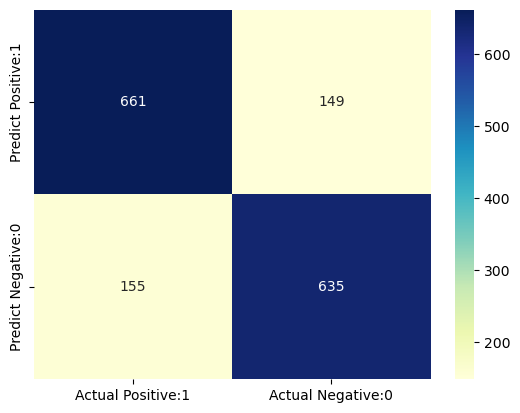

In [18]:
cm = confusion_matrix(val_y, pred_y)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

plt.show()

### 変数重要度の確認

In [19]:
df_importance = pd.DataFrame(model.feature_importances_, index=feature_cols, columns=['importance'])
df_importance['importance'] = df_importance['importance'] / sum(df_importance['importance'])
display(df_importance)

,importance
blueFirstBlood,0.050878
blueKills,0.040424
blueDeaths,0.041748
blueAssists,0.035619
blueEliteMonsters,0.058456
blueDragons,0.042215
blueTotalGold,0.149120
blueTotalExperience,0.581538


In [20]:
# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df): 
    n_features = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot.index                         # 特徴量のカラム名を取得
    plt.yticks(np.arange(n_features), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル

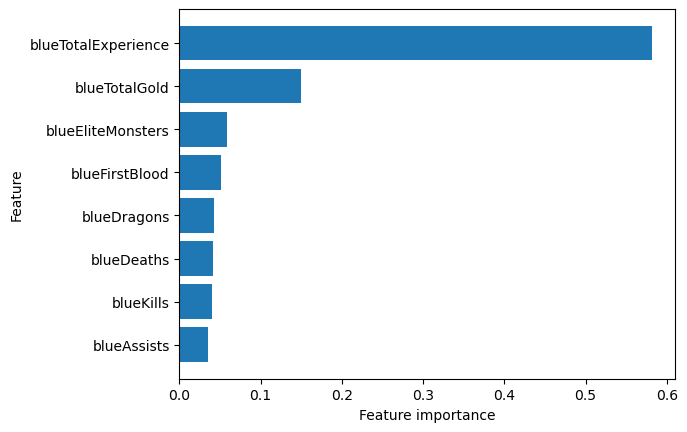

In [21]:
plot_feature_importance(df_importance)

## CatBoost実装

In [22]:
feature_cols = list(df_train.drop(COL_BLUEWINS, axis=1).columns)

train_x = df_train.drop(COL_BLUEWINS, axis=1)
train_y = df_train[COL_BLUEWINS]

val_x = df_val.drop(COL_BLUEWINS, axis=1)
val_y = df_val[COL_BLUEWINS]

In [23]:
train_x.head()

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
1001,1,11,3,8,1,1,18274,18472
7360,0,6,11,7,0,0,20619,17256
5234,1,6,3,5,1,0,16961,18201
7390,0,9,5,8,0,0,18117,18472
6841,1,9,4,9,0,0,14536,17256


In [24]:
model = catb.CatBoostClassifier(
    custom_loss=['Accuracy'], 
    random_seed=random_state
                               )
model.fit(train_x, train_y, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.02276
0:	learn: 0.6825752	total: 125ms	remaining: 2m 5s
1:	learn: 0.6730174	total: 158ms	remaining: 1m 18s
2:	learn: 0.6638879	total: 192ms	remaining: 1m 3s
3:	learn: 0.6543759	total: 229ms	remaining: 57.1s
4:	learn: 0.6463655	total: 261ms	remaining: 51.9s
5:	learn: 0.6390944	total: 291ms	remaining: 48.3s
6:	learn: 0.6322786	total: 321ms	remaining: 45.5s
7:	learn: 0.6250925	total: 351ms	remaining: 43.5s
8:	learn: 0.6187264	total: 384ms	remaining: 42.2s
9:	learn: 0.6126346	total: 416ms	remaining: 41.1s
10:	learn: 0.6061304	total: 452ms	remaining: 40.6s
11:	learn: 0.6017958	total: 483ms	remaining: 39.8s
12:	learn: 0.5959793	total: 514ms	remaining: 39s
13:	learn: 0.5905142	total: 544ms	remaining: 38.3s
14:	learn: 0.5860614	total: 573ms	remaining: 37.6s
15:	learn: 0.5813937	total: 603ms	remaining: 37.1s
16:	learn: 0.5764726	total: 632ms	remaining: 36.6s
17:	learn: 0.5713987	total: 664ms	remaining: 36.2s
18:	learn: 0.5672096	total: 693ms	remaining: 35.8s
19:	learn: 0.

In [25]:
# 検証データを用いて予測
pred_y = model.predict(val_x)

accuracy = accuracy_score(pred_y, val_y)
print(f"accuracy score: {accuracy:0.4f}")

accuracy score: 0.8037


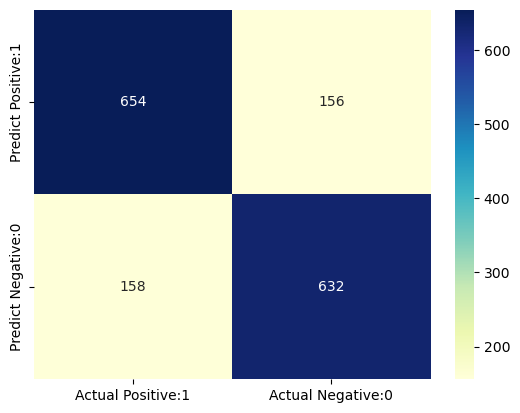

In [26]:
cm = confusion_matrix(val_y, pred_y)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

plt.show()

### 変数重要度の確認

In [27]:
df_importance = pd.DataFrame(model.feature_importances_, index=feature_cols, columns=['importance'])
df_importance['importance'] = df_importance['importance'] / sum(df_importance['importance'])
display(df_importance)

,importance
blueFirstBlood,0.041972
blueKills,0.109194
blueDeaths,0.113343
blueAssists,0.103054
blueEliteMonsters,0.056262
blueDragons,0.027808
blueTotalGold,0.300287
blueTotalExperience,0.248081


In [28]:
# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df): 
    n_features = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot.index                         # 特徴量のカラム名を取得
    plt.yticks(np.arange(n_features), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル

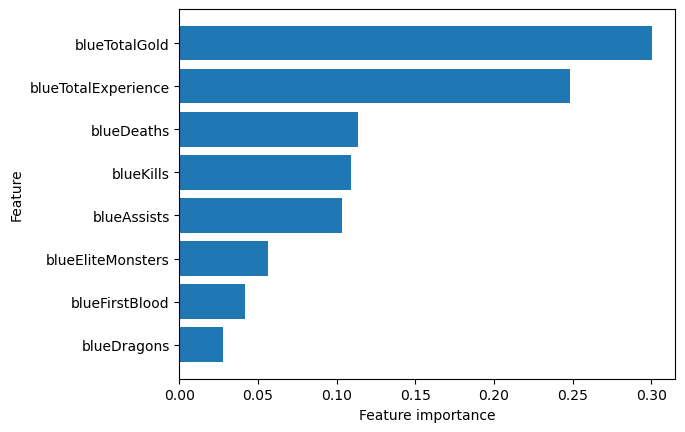

In [29]:
plot_feature_importance(df_importance)